In [68]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import math
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

In [69]:
#iris_dataset = load_iris()
#X = pd.DataFrame(iris_dataset.data, columns = iris_dataset.feature_names)
#y = iris_dataset.target

In [1]:
#df = pd.read_csv('./sonar/sonar.csv')
#X = df.drop('R', axis = 1)
#y = df["R"]
#y.replace(['R', 'M'], [0, 1], inplace = True)

In [71]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
#y_train.shape

In [72]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
#X_test = scaler.transform(X_test)

In [73]:
#y_train = np.array(y_train)
#y_train = y_train.reshape((1, y_train.shape[0]))
#y_val = np.array(y_val)
#y_val = y_val.reshape((1, y_val.shape[0]))
#y_test = np.array(y_test)
#y_test = y_test.reshape((1, y_test.shape[0]))

In [74]:
#layer_dims = [X_train.shape[1], 30, 20, 3]

In [75]:
class NeuralNetwork:
    
    def __init__(self, 
                 layers_dims, 
                 epochs = 10, 
                 alpha = 1e-3, 
                 optimizer = 'Adam', # Adam or gradient-descent
                 minibatch_size = None,
                 beta_1 = 0.9, 
                 beta_2 = 0.999,
                 epsilon = 1e-8):
        
        self.layers_dims = layers_dims
        self.epochs = epochs
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.parameters = self._initialize_parameters()
        self.grads = {}
        self.costs = []
        if minibatch_size:
            self.minibatch_size = minibatch_size
        else:
            self.minibatch_size = 0
        self.output_activation = ''
        if optimizer.lower() == 'gradient-descent':
            self.optimizer = 'gradient-descent'
        else:
            self.optimizer = 'Adam'
            self.adam = self._initialize_adam()
            
    def fit(self, X, y, verbose = 1):
        
        if(not self.minibatch_size):
            self.minibatch_size = y.shape[0]
            
        if len(np.unique(y)) > 2:
            self.output_activation = 'softmax'
            assert(self.layers_dims[-1] == len(np.unique(y)))
            temp = np.zeros((y.size, y.max() + 1))
            temp[np.arange(y.size), y] = 1
            y = temp.T
        else:
            self.output_activation = 'sigmoid'
            y = np.array(y_train)
            y = y.reshape((1, y.shape[0]))
        X = X.T
        #print(X.shape)
        for i in range(self.epochs):
            #sampled_idxs = []
            #idxs = np.arange(y.shape)
            for j in range(int(X.shape[1]/self.minibatch_size)):
                #try:
                    #idxs = np.random.choice(y.shape[0], self.minibatch_size, replace = False)
                    #sampled_idxs += idxs 
                #except:
                    #idxs = np.random.choice(y.shape[0], y.shape[0] % self.minibatch_size, replace = False)
                idxs = random.sample(range(X.shape[1]), self.minibatch_size)
                X = X[:, idxs]
                y = y[:, idxs]
                AL, caches = self._forward_propagation(X)
                cost = self._compute_cost(AL, y)
                self._backward_propagation(AL, y, caches)
                self._update_parameters()
            if verbose:
                if i % 10 == 0 or i == self.epochs - 1:
                    print("Cost after epoch {}: {}".format(i, np.squeeze(cost)))
                if i % 1 == 0 or i == self.epochs:
                    self.costs.append(cost)
        
    def _initialize_parameters(self):
        
        parameters = {}

        for l in range(1, len(self.layers_dims)):
            np.random.seed(0)
            parameters["w" + str(l)] = np.random.randn(self.layers_dims[l], self.layers_dims[l - 1]) * 0.01
            parameters["b" + str(l)] = np.zeros((self.layers_dims[l], 1))
        
        return parameters
    
    def _initialize_adam(self):
        adam = {}

        for l in range(1, len(self.layers_dims)):
            adam["vdw" + str(l)] = np.zeros((self.layers_dims[l], self.layers_dims[l - 1]))
            adam["sdw" + str(l)] = np.zeros((self.layers_dims[l], self.layers_dims[l - 1]))
            adam["vdb" + str(l)] = np.zeros((self.layers_dims[l], 1))
            adam["sdb" + str(l)] = np.zeros((self.layers_dims[l], 1))
            
        return adam
    
    def _linear_forward(self, A, w, b):
        
        Z = np.dot(w, A) + b
        cache = (A, w, b)
        return Z, cache
    
    def _sigmoid(self, Z):
        
        a = 1/(1 + np.exp(-Z))
        cache = Z
        return a, cache

    def _relu(self, Z):
        
        a = np.maximum(0, Z)
        cache = Z
        return a, cache
    
    def _softmax(self, Z):
        a = np.exp(Z)/np.sum(np.exp(Z), axis = 0, keepdims = True)
        cache = Z
        return a, cache
    
    def _activation_forward(self, A_prev, w, b, activation):
        
        if activation == 'sigmoid':
            Z, linear_cache = self._linear_forward(A_prev, w, b)
            A, activation_cache = self._sigmoid(Z)

        elif activation == 'relu':
            Z, linear_cache = self._linear_forward(A_prev, w, b)
            A, activation_cache = self._relu(Z)
            
        elif activation == 'softmax':
            Z, linear_cache = self._linear_forward(A_prev, w, b)
            A, activation_cache = self._softmax(Z)
        
        cache = (linear_cache, activation_cache)
        return A, cache
    
    def _forward_propagation(self, X):
    
        caches = []
        A = X
        l = len(self.parameters) // 2
        for i in range(1, l):
            A_prev = A
            A, cache = self._activation_forward(A, self.parameters["w" + str(i)], self.parameters["b" + str(i)], activation = "relu")
            caches.append(cache)
        if self.output_activation != 'softmax':
            AL, cache = self._activation_forward(A, self.parameters["w" + str(l)], self.parameters["b" + str(l)], activation = "sigmoid")
        else:
            AL, cache = self._activation_forward(A, self.parameters["w" + str(l)], self.parameters["b" + str(l)], activation = "softmax")
        caches.append(cache)

        return AL, caches
    
    def _compute_cost(self, AL, y):
    
        ## cross-entropy cost: for binary classification
        m = y.shape[1]
        if self.output_activation == 'sigmoid':
            cost = (1./m) * (-np.dot(y, np.log(1e-9 + AL.T)) - np.dot(1 - y, np.log(1e-9 + 1 - AL.T)))
        else:
            #print(y)
            cost = -(1./m) * (np.sum(np.multiply(y, np.log(1e-9 + AL))))
            #cost = -np.mean(y * np.log(AL + 1e-9))
        #print(cost)
        cost = np.squeeze(cost)
        #print(cost)
        return cost
    
    def _linear_backward(self, dZ, cache):
        A_prev, w, b = cache
        m = A_prev.shape[1]
        dw = 1./m * np.dot(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(w.T, dZ)
        
        #print(dA_prev, dw, db)
        return dA_prev, dw, db
    
    def _backward(self, dA, cache, activation):
        Z = cache
        if activation == 'relu':
            dZ = np.array(dA, copy = True)
            dZ[Z <= 0] = 0
            return dZ

        elif activation == 'sigmoid':
            sig = 1/(1 + np.exp(-Z))
            dZ = dA * sig * (1 - sig)
            return dZ
            
        
    def _activation_backward(self, dA, cache, activation):
        linear_cache, activation_cache = cache
        dZ = self._backward(dA, activation_cache, activation)
        dA_prev, dw, db = self._linear_backward(dZ, linear_cache)

        return dA_prev, dw, db
    
    
    def _backward_propagation(self, AL, y, caches):
    
        l = len(caches)
        m = AL.shape[1]
        y = y.reshape(AL.shape)
        cache = caches[l - 1]
        if self.output_activation != 'softmax':
            dAL = - (np.divide(y, (1e-9 + AL)) - np.divide(1 - y, (1e-9 + 1 - AL)))
            self.grads["dA" + str(l - 1)], self.grads["dw" + str(l)], self.grads["db" + str(l)] = self._activation_backward(dAL, cache, activation = self.output_activation)
        else:
            dZ = AL - y
            linear_cache, activation_cache = cache
            self.grads["dA" + str(l - 1)], self.grads["dw" + str(l)], self.grads["db" + str(l)] = self._linear_backward(dZ, linear_cache)


        for i in reversed(range(l - 1)):
            cache = caches[i]
            dA_prev_temp, dw_temp, db_temp = self._activation_backward(self.grads["dA" + str(i + 1)], cache, activation = "relu")
            self.grads["dA" + str(i)] = dA_prev_temp
            self.grads["dw" + str(i + 1)] = dw_temp
            self.grads["db" + str(i + 1)] = db_temp
    
    def _update_parameters(self):
        l = len(self.parameters) // 2
        if self.optimizer == 'Adam':
            for i in range(l):
                self.adam["vdw" + str(i + 1)] = (self.beta_1 * self.adam["vdw" + str(i + 1)]) + ((1 - self.beta_1) * self.grads["dw" + str(i + 1)])
                self.adam["vdb" + str(i + 1)] = (self.beta_1 * self.adam["vdb" + str(i + 1)]) + ((1 - self.beta_1) * self.grads["db" + str(i + 1)])
                self.adam["sdw" + str(i + 1)] = (self.beta_2 * self.adam["sdw" + str(i + 1)]) + ((1 - self.beta_2) * np.square(self.grads["dw" + str(i + 1)]))
                self.adam["sdb" + str(i + 1)] = (self.beta_2 * self.adam["sdb" + str(i + 1)]) + ((1 - self.beta_2) * np.square(self.grads["db" + str(i + 1)]))
                self.parameters["w" + str(i + 1)] = self.parameters["w" + str(i + 1)] - self.alpha * (self.adam["vdw" + str(i + 1)]/np.sqrt(self.adam["sdw" + str(i + 1)] + self.epsilon))
                self.parameters["b" + str(i + 1)] = self.parameters["b" + str(i + 1)] - self.alpha * (self.adam["vdb" + str(i + 1)]/np.sqrt(self.adam["sdb" + str(i + 1)] + self.epsilon))
                
        else:
            for i in range(l):
                self.parameters["w" + str(i + 1)] = self.parameters["w" + str(i + 1)] - self.alpha * self.grads["dw" + str(i + 1)]
                self.parameters["b" + str(i + 1)] = self.parameters["b" + str(i + 1)] - self.alpha * self.grads["db" + str(i + 1)] 
                
    def predict(self, X, y):
        y = np.array(y)
        y = y.reshape((1, y.shape[0]))
        X = X.T
        m = X.shape[1]
        p = np.zeros((1, m))
        probs, _ = self._forward_propagation(X)
        #print(probs)
        if self.output_activation == 'softmax':
            p = np.argmax(probs, axis = 0)
        else:
            for i in range(0, probs.shape[1]):
                if probs[0, i] > 0.5:
                    p[0, i] = 1
                else:
                    p[0, i] = 0

        acc_score = (np.sum((p == y))/m) * 100
        return p, acc_score

In [76]:
#nn = NeuralNetwork(layer_dims, alpha = 0.001, epochs = 100, minibatch_size = 64)
#nn.fit(X_train, y_train)

In [77]:
#predict, score = nn.predict(X_test, y_test)

In [78]:
#print(f"Accuracy: {score:.2f}%")

In [79]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test_orig = X_test
print(X_test_orig.shape)

(10000, 28, 28)


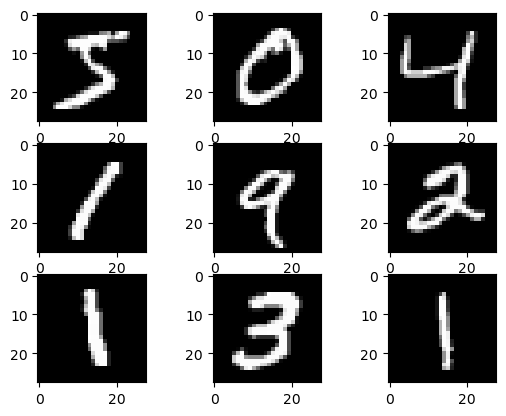

In [80]:
figure = plt.figure()
for i in range(9):
    figure.add_subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))

plt.show()

In [81]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train = X_train/255.
X_test = X_test/255.

In [82]:
X_train.shape

(60000, 784)

In [83]:
layers_dims = [X_train.shape[1], 256, 128, 10]

In [84]:
nn = NeuralNetwork(layers_dims, alpha = 0.001, epochs = 100, minibatch_size = 2048)
nn.fit(X_train, y_train)

Cost after epoch 0: 0.547516151842001
Cost after epoch 10: 0.3394927338691397
Cost after epoch 20: 0.23449708821624446
Cost after epoch 30: 0.16473608330082679
Cost after epoch 40: 0.11323266392365022
Cost after epoch 50: 0.07370099659281076
Cost after epoch 60: 0.04463737698469437
Cost after epoch 70: 0.026153627013627872
Cost after epoch 80: 0.015821132127277187
Cost after epoch 90: 0.010415875896947865
Cost after epoch 99: 0.007681245290579833


In [85]:
predict, score = nn.predict(X_test, y_test)

In [86]:
print(f"Accuracy: {score:.2f}%")

Accuracy: 90.53%


In [87]:
mislabeled_indices = np.asarray(np.where(predict != y_test))

In [88]:
mislabeled_indices = mislabeled_indices.reshape(mislabeled_indices.shape[1], 1)

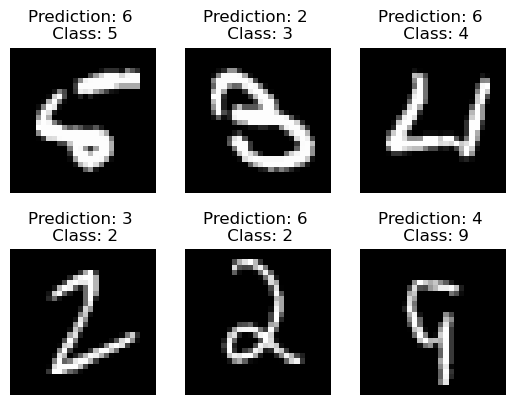

In [89]:
for i in range(6):
    index = mislabeled_indices[i][0]
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test_orig[index,:].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title("Prediction: " + str(predict[index]) + " \n Class: " + str(y_test[index]))
    

## Finding best hyperparameters

In [90]:
learning_rate = [0.001, 0.01, 0.1]
batch_size = [256, 512, 1028, 2048, 4096]
epochs = [100, 200]
results = []
for alpha in learning_rate:
    for size in batch_size:
        for epoch in epochs:
            nn = NeuralNetwork(layers_dims, alpha = alpha, epochs = epoch, minibatch_size = size)
            nn.fit(X_train, y_train, verbose = 0)
            predict, score = nn.predict(X_test, y_test)
            res = {'learning rate': alpha, 'batch size': size, 'epochs': epoch, 'score': score}
            results.append(res)

In [91]:
results = pd.DataFrame(results)
results = results.sort_values(by='score', ascending=False)
results

,learning rate,batch size,epochs,score
9,0.001,4096,200,93.41
8,0.001,4096,100,92.38
18,0.010,4096,100,92.11
7,0.001,2048,200,91.73
19,0.010,4096,200,90.47
6,0.001,2048,100,89.30
16,0.010,2048,100,89.27
17,0.010,2048,200,88.31
5,0.001,1028,200,87.94
15,0.010,1028,200,87.65


In [92]:
max_index = np.argmax(results['score'])


In [93]:
learning_rate = results.iloc[0, :]['learning rate']
batch_size = results.iloc[0, :]['batch size']
epochs = results.iloc[0, :]['epochs']

In [94]:
nn = NeuralNetwork(layers_dims, alpha = learning_rate, epochs = int(epochs), minibatch_size = int(batch_size))
nn.fit(X_train, y_train)

Cost after epoch 0: 2.0592522177589845
Cost after epoch 10: 0.7599621432374718
Cost after epoch 20: 0.46289036048649135
Cost after epoch 30: 0.3278182294852071
Cost after epoch 40: 0.25555566808169383
Cost after epoch 50: 0.20604740531834864
Cost after epoch 60: 0.16348619545355608
Cost after epoch 70: 0.12671786002753505
Cost after epoch 80: 0.09505482687438965
Cost after epoch 90: 0.068567891622082
Cost after epoch 100: 0.0477661441054921
Cost after epoch 110: 0.03268703389681877
Cost after epoch 120: 0.0225561523857057
Cost after epoch 130: 0.015949238068977405
Cost after epoch 140: 0.011650938101692177
Cost after epoch 150: 0.00881523721778953
Cost after epoch 160: 0.006914260493585812
Cost after epoch 170: 0.005611034984802098
Cost after epoch 180: 0.004686050801120773
Cost after epoch 190: 0.00399972202485685
Cost after epoch 199: 0.003520530836539137


In [95]:
predict, score = nn.predict(X_test, y_test)

In [96]:
print(f"Accuracy: {score:.2f}%")

Accuracy: 92.85%
